# Cross-validated SVM and kNN
___

*Using the same credit card data set https://archive.ics.uci.edu/ml/datasets/Credit+Approval, I will use cross-validation and the `ksvm` / `kknn` functions to find a good classifier*
___





### Cross validation

To perfrom k-fold cross validation we must perform the following steps:

* Preprocess data (scaling, standardization, remove NULLs, etc.)
* Split the data into a training/test set (80% training-20% test or 70% training-30% test are common choices)
    * Normally, we would not split the data to do k-fold cross validation, but I am interested in doing a comparison between the model produced by cv.kknn and the popular R package `caret`
* Pick a value for k
* Train/validate given model of choice
* Make predictions on our test set of data
    * If comparing multiple models of different kinds use model performance on test set of data to pick optimal model
        * This verbage confused me for the longest time, but I stand by my decision to split the data in this case. My reason being I need an 80% training/validation set of data to build two different models using k-fold cross validation and a new set of data (never seen by the models) to objectively compare the differences in the cv.kknn and the `caret` methods for doing cross-validation.



In [1]:
# Load libraries and set seed

library(caret)
library(kernlab)
library(kknn)

require(caret)
require(kernlab)
require(kknn)

Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: ggplot2

Attaching package: 'kernlab'

The following object is masked from 'package:ggplot2':

    alpha

Warning message:
"package 'kknn' was built under R version 3.4.2"
Attaching package: 'kknn'

The following object is masked from 'package:caret':

    contr.dummy



In [2]:
set.seed(37)



### Load data



In [3]:
data <- read.table("credit_card_data-headers.txt", stringsAsFactors = FALSE, 
                   header = TRUE)



### Check head of R DataFrame



In [4]:
head(data)

A1,A2,A3,A8,A9,A10,A11,A12,A14,A15,R1
1,30.83,0.000,1.25,1,0,1,1,202,0,1
0,58.67,4.460,3.04,1,0,6,1,43,560,1
0,24.50,0.500,1.50,1,1,0,1,280,824,1
1,27.83,1.540,3.75,1,0,5,0,100,3,1
1,20.17,5.625,1.71,1,1,0,1,120,0,1
1,32.08,4.000,2.50,1,1,0,0,360,0,1




### Check str of R DataFrame object



In [5]:
str(data)

'data.frame':	654 obs. of  11 variables:
 $ A1 : int  1 0 0 1 1 1 1 0 1 1 ...
 $ A2 : num  30.8 58.7 24.5 27.8 20.2 ...
 $ A3 : num  0 4.46 0.5 1.54 5.62 ...
 $ A8 : num  1.25 3.04 1.5 3.75 1.71 ...
 $ A9 : int  1 1 1 1 1 1 1 1 1 1 ...
 $ A10: int  0 0 1 0 1 1 1 1 1 1 ...
 $ A11: int  1 6 0 5 0 0 0 0 0 0 ...
 $ A12: int  1 1 1 0 1 0 0 1 1 0 ...
 $ A14: int  202 43 280 100 120 360 164 80 180 52 ...
 $ A15: int  0 560 824 3 0 0 31285 1349 314 1442 ...
 $ R1 : int  1 1 1 1 1 1 1 1 1 1 ...




### Check summary of R DataFrame object



In [6]:
summary(data)

       A1               A2              A3               A8        
 Min.   :0.0000   Min.   :13.75   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:0.0000   1st Qu.:22.58   1st Qu.: 1.040   1st Qu.: 0.165  
 Median :1.0000   Median :28.46   Median : 2.855   Median : 1.000  
 Mean   :0.6896   Mean   :31.58   Mean   : 4.831   Mean   : 2.242  
 3rd Qu.:1.0000   3rd Qu.:38.25   3rd Qu.: 7.438   3rd Qu.: 2.615  
 Max.   :1.0000   Max.   :80.25   Max.   :28.000   Max.   :28.500  
       A9              A10              A11              A12        
 Min.   :0.0000   Min.   :0.0000   Min.   : 0.000   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.: 0.000   1st Qu.:0.0000  
 Median :1.0000   Median :1.0000   Median : 0.000   Median :1.0000  
 Mean   :0.5352   Mean   :0.5612   Mean   : 2.498   Mean   :0.5382  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.: 3.000   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :67.000   Max.   :1.0000  
      A14               A15              



### Split data into training and test set

I went with an 80/20 split for my data. I picked this split over 70/30 because I am using k-fold repeated cross validation (cv) to train/validate the model and want to insure the model has as much data as possible in the training/validation stage.



In [7]:
training_set <- createDataPartition(y = data$R1, p= 0.8, list = FALSE)
training <- data[training_set,]
testing <- data[-training_set,]
testing_attributes <- testing[,-11]
testing_correct_responses <- testing$R1



### k-fold cross validation using cv.kknn

I decided to only explore different values of k and left the kernel set to the default 'rectangular'.



In [8]:
# init 0's vector for model accuracy

knn_model_cv_accuracy_tracker <- rep(0,60)

for (k in 1:60) {
    
    # build cross-validated kNN model
    knn_model_cv <- cv.kknn(R1~.,training,
                                        kcv=10,
                                        k=k,
                                        scale=TRUE)
    
    # init 0's vector for model predictions
    knn_model_cv_predictions <- as.integer(knn_model_cv[[1]][,2] + 0.5)
    
    # add cross-validated kNN model k's accuracy to the tracker
    knn_model_cv_accuracy_tracker[k] <- sum(knn_model_cv_predictions == training$R1)
}



### Optimal kNN model accuracy on training/validation set



In [9]:
max(knn_model_cv_accuracy_tracker) / length(training$R1)

[1] 0.8530534



### Optimal kNN model error on training/validation set



In [10]:
1 - max(knn_model_cv_accuracy_tracker) / length(training$R1)

[1] 0.1469466



### Optimal k value (k as in kNN)



In [11]:
which(knn_model_cv_accuracy_tracker==max(knn_model_cv_accuracy_tracker))

[1] 34



### Plot kNN model accuracy vs k number of neighbors



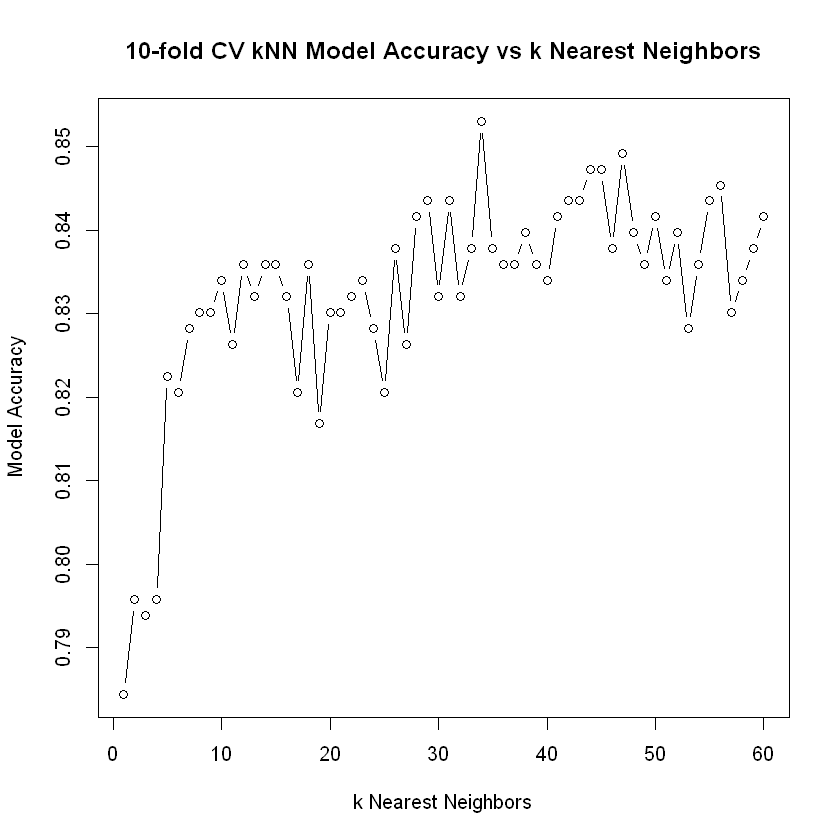

In [12]:
plot(c(1:60),knn_model_cv_accuracy_tracker/length(training$R1), type ='b', 
     main ='10-fold CV kNN Model Accuracy vs k Nearest Neighbors', 
     xlab = 'k Nearest Neighbors', ylab = 'Model Accuracy')



### Making predictions on test set using optimal k



In [13]:
# init 0's vector for predictions
cv_kknn_final_test_model_pred <- rep(0,(nrow(testing)))

for (i in 1:nrow(testing)){

    # data[-i] removes row i of data when finding k nearest neighbors in training
    # else a perfect match between data point and itself would exist in test

    cv_kknn_final_test_model=kknn(R1~.,testing[-i,],testing[i,],
                                  k=which(knn_model_cv_accuracy_tracker==max(knn_model_cv_accuracy_tracker)), 
                                  scale = TRUE)

    cv_kknn_final_test_model_pred[i] <- as.integer(fitted(cv_kknn_final_test_model)+0.5)
  }
cv_kknn_final_test_model_accuracy = sum(cv_kknn_final_test_model_pred == testing[,11]) / nrow(testing)



### Optimal kNN model accuracy on test set



In [14]:
cv_kknn_final_test_model_accuracy

[1] 0.8692308



### Optimal kNN model error on test set



In [15]:
1 - cv_kknn_final_test_model_accuracy

[1] 0.1307692



### Difference between test and training set accuracy

Answers the question:

*** Is our model capable of abstracting to new data points? Or is it overfitting to the training dataset?***



In [16]:
cv_kknn_final_test_model_accuracy - 
(max(knn_model_cv_accuracy_tracker) / length(training$R1))

[1] 0.01617733



### cv.kknn commentary

Interesting. Our model performed better on the test set of data then on the training/validation set. This is probably due to the randomness of the data split. Lets rerun the whole process for k [1,20].

*** Is the optimal model built with 100% of the data points overfitting the data? ***



In [17]:
# init 0's vector for predictions
knn_optimal_model_pred <- rep(0,(nrow(data)))

for (i in 1:nrow(data)){

    # data[-i] removes row i of data when finding k nearest neighbors in training
    # else a perfect match between data point and itself would exist in test

    knn_optimal_model_pred=kknn(R1~.,data[-i,],data[i,],k=12, scale = TRUE)

    knn_optimal_model_pred[i] <- as.integer(fitted(knn_optimal_model_pred)+0.5)
  }
knn_optimal_model_accuracy = sum(knn_optimal_model_pred == data[,11]) / nrow(data)

In [18]:
knn_optimal_model_accuracy

[1] 0.853211



### k-fold cross validation using cv.kknn k [1,20]



In [19]:
# init 0's vector for model accuracy

knn_model_cv_accuracy_tracker <- rep(0,20)

for (k in 1:20) {
    
    # build cross-validated kNN model
    knn_model_cv <- cv.kknn(R1~.,training,
                                        kcv=10,
                                        k=k,
                                        scale=TRUE)
    
    # init 0's vector for model predictions
    knn_model_cv_predictions <- as.integer(knn_model_cv[[1]][,2] + 0.5)
    
    # add cross-validated kNN model k's accuracy to the tracker
    knn_model_cv_accuracy_tracker[k] <- sum(knn_model_cv_predictions == training$R1)
}



### Optimal kNN model accuracy on training/validation set



In [20]:
max(knn_model_cv_accuracy_tracker) / length(training$R1)

[1] 0.8416031



### Optimal kNN model error on training/validation set



In [21]:
1 - max(knn_model_cv_accuracy_tracker) / length(training$R1)

[1] 0.1583969



### Optimal k value (k as in kNN)



In [22]:
which(knn_model_cv_accuracy_tracker==max(knn_model_cv_accuracy_tracker))

[1] 12



### Plot kNN model accuracy vs k number of neighbors



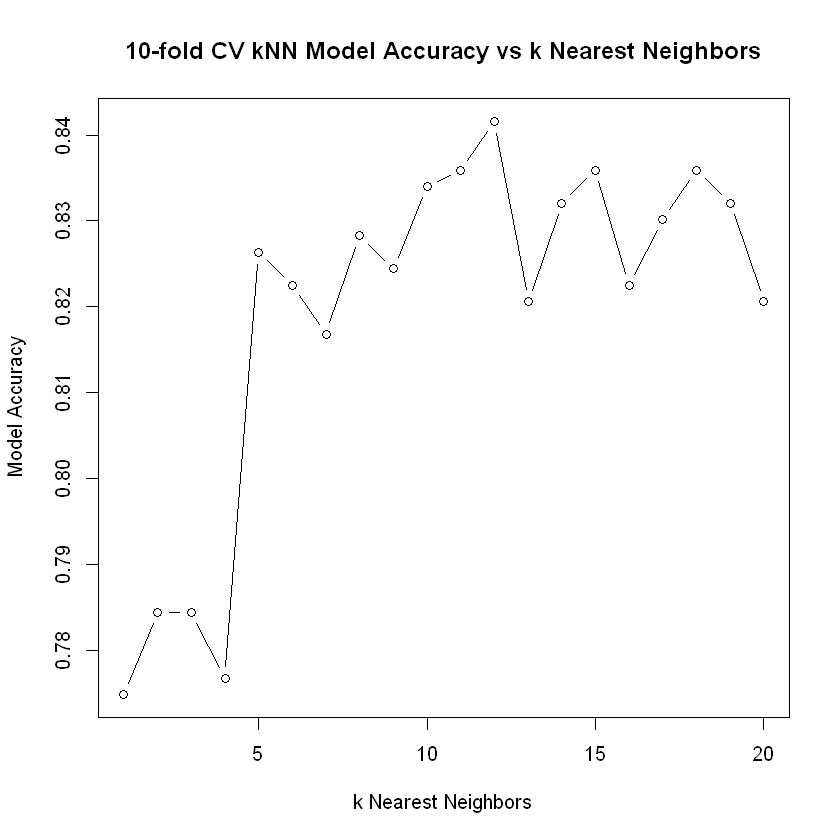

In [23]:
plot(c(1:20),knn_model_cv_accuracy_tracker/length(training$R1), type ='b', 
     main ='10-fold CV kNN Model Accuracy vs k Nearest Neighbors', 
     xlab = 'k Nearest Neighbors', ylab = 'Model Accuracy')



### Difference between optimal model accuracy (all data) and optimal model accuracy (cross-validation)

We compare model's using the validation set of data (if data is split).



In [24]:
difference_as_a_percentage <- (knn_optimal_model_accuracy - (max(knn_model_cv_accuracy_tracker)
                                                                 / length(training$R1))) * 100

In [25]:
cat(format(round(difference_as_a_percentage, 2), nsmall = 2))
cat("% difference in model accuracy between kNN model run on 100% of dataset and 
    cross validated kNN model run on 80% of dataset")

1.16% difference in model accuracy between kNN model run on 100% of dataset and 
    cross validated kNN model run on 80% of dataset



### Commentary

Let's recap how we compared the model outputs using all the data and 80% of the data:


1. Different kNN models were tested on the entire dataset using varying values of k [1,20]
    * k and corresponding model accuracy were tracked
    * An optimal model was found with k = 12
    * Optimal model accuracy was found to be 0.853   
2. Different kNN models were tested using a cross-validation approach
    * Raw data was split 80/20 into training/validation and test sets
    * Different values of k [1,20] were tested on the 80% training/validation dataset
    * An optimal model was found with k = 12       
3. Using the optimal model (k = 12) found in step 2, we tested the model performance on the 20% test set of data
    * Model accuracy was found to be 0.823       
4. Optimal model accuracies from steps 1 and 3 were compared
    * A ~1% difference between the two models was observed
    
    
*** So what does this 1% represent? ***

The observed 1% difference between the two models is how much our optimal model built using all of the data is overfitting the dataset. Considering we are building the model with 100% of the dataset, this percentage of overfitting is not that bad!





## Cross-validated kNN alternate method: `caret`





### Create k nearest neighbor model using k-fold repeated cv using `caret`

* To perform k-fold cross validation I used the popular R package `caret` 

The documentation for `caret` can be found here: https://cran.r-project.org/web/packages/caret/caret.pdf

Specifically, I am using the `train` function which can be found starting on page 154 of the .pdf linked above.

* `train` is a general purpose function provided in `caret` that allows the user to train a variety of models
    * For the full list of models available by tag in the `train` function, checkout the following reference: http://topepo.github.io/caret/train-models-by-tag.html

For our specific use case (subclass 'formula') of `train` we are interested in the following parameters:

* `x` is a binary datatype (R factor object) followed by the attributes we'd like to predict x using
    * ~. in R means use all attributes
    
    
* `data` is the source data that our response and attributes come from (training/validation set)


* `method` is a parameter used to define the type of model we would like to train ('knn' in this case)
    
    
* `trControl` is a list of values that define how this function acts (how we define the cross validation to take place)
    * I set up cross-validation based on https://stackoverflow.com/q/28451376
    
    
* `preProcess` allows us to preProcess our data using a vector of tags
    * more info on options for the preProcess `method` parameter can be found on page 113 of the `caret` documentation .pdf
    * "scale" sets the standard deviation of all points equal reference: https://www.biomedware.com/files/documentation/boundaryseer/Preparing_data/Methods_for_data_standardization.htm


* `tuneLength` is an integer denoting the amount of granularity in the tuning parameter grid. By default, this argument is the number of levels for each tuning parameters that should be generated by the `train` function. In layman terms, this means 'what is the max number of k (k as in kNN) values to try' when tuning the model



In [26]:
# Setup k-fold cross validation with knn model with k=10 (k refering to k in cross-validation NOT knn)

train_control<- trainControl(method="repeatedcv", number=10, repeats=5)

caret_knn_model_10_fold_cv <- train(as.factor(R1) ~., data = training, method = "knn",
                 trControl=train_control,
                 preProcess = c("scale"),
                 tuneLength = 29)



### Print cv kNN model results



In [27]:
print(caret_knn_model_10_fold_cv)

k-Nearest Neighbors 

524 samples
 10 predictor
  2 classes: '0', '1' 

Pre-processing: scaled (10) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 472, 471, 471, 472, 472, 472, ... 
Resampling results across tuning parameters:

  k   Accuracy   Kappa    
   5  0.8191322  0.6363346
   7  0.8309316  0.6615418
   9  0.8321081  0.6628818
  11  0.8301917  0.6586653
  13  0.8371078  0.6720412
  15  0.8332396  0.6638544
  17  0.8328477  0.6629052
  19  0.8302059  0.6569871
  21  0.8378254  0.6720484
  23  0.8409246  0.6780943
  25  0.8371365  0.6706556
  27  0.8382105  0.6725970
  29  0.8401336  0.6763269
  31  0.8386169  0.6729879
  33  0.8363383  0.6680574
  35  0.8371147  0.6692671
  37  0.8371220  0.6693287
  39  0.8386390  0.6721438
  41  0.8405330  0.6759110
  43  0.8390018  0.6727847
  45  0.8382323  0.6709577
  47  0.8378332  0.6701464
  49  0.8397420  0.6738233
  51  0.8408814  0.6762534
  53  0.8408666  0.6761772
  55  0.8381960  0.6707041
  57  0



### Plot cv kNN model results



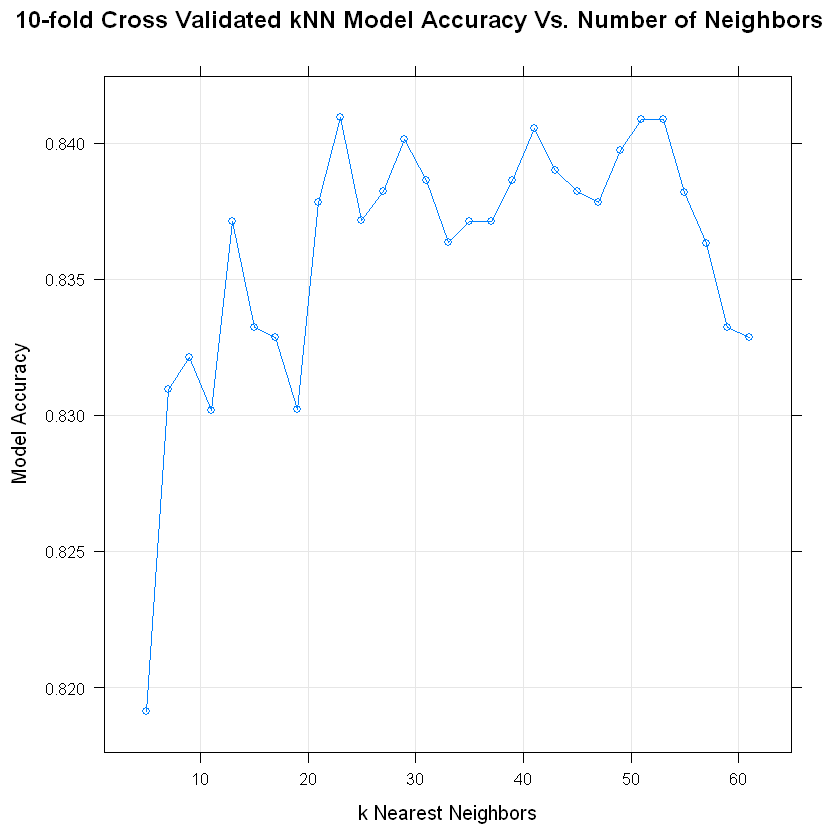

In [28]:
plot(caret_knn_model_10_fold_cv, 
     main="10-fold Cross Validated kNN Model Accuracy Vs. Number of Neighbors", 
     xlab="k Nearest Neighbors", ylab="Model Accuracy")



### Extracting important attributes from cross validated kNN model

reference: https://www.analyticsvidhya.com/blog/2016/12/practical-guide-to-implement-machine-learning-with-caret-package-in-r-with-practice-problem/



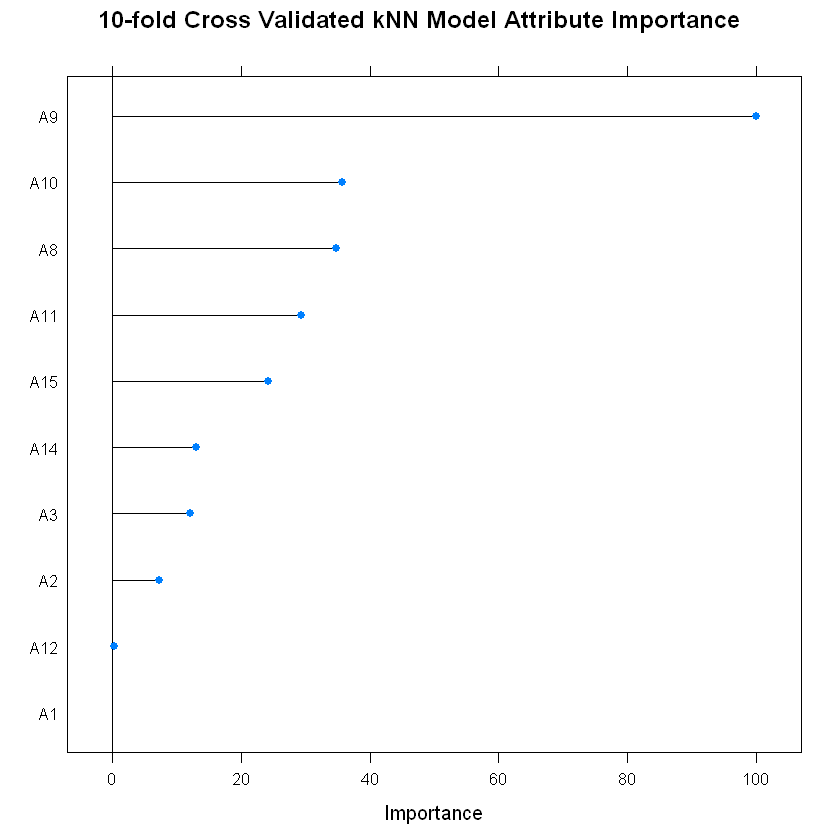

In [29]:
plot(varImp(object=caret_knn_model_10_fold_cv), 
     main="10-fold Cross Validated kNN Model Attribute Importance")



Attribute A9 is our most important for predicting the response.





### Now that we know our optimal value of k = 23, lets build one final model using all our training data this time

This time I will build the kNN model using the kNN function with k = 23,



In [30]:
# init 0's vector for predictions
caret_knn_final_train_model_pred <- rep(0,(nrow(training)))

for (i in 1:nrow(training)){

    # data[-i] removes row i of data when finding k nearest neighbors in training
    # else a perfect match between data point and itself would exist in test

    caret_knn_final_train_model=kknn(R1~.,training[-i,],training[i,],k=23, scale = TRUE)

    caret_knn_final_train_model_pred[i] <- as.integer(fitted(caret_knn_final_train_model)+0.5)
  }
caret_knn_final_train_model_accuracy = sum(caret_knn_final_train_model_pred == training[,11]) / nrow(training)
caret_knn_final_train_model_accuracy

[1] 0.8282443



### Making predictions on test set



In [31]:
# init 0's vector for predictions
caret_knn_final_test_model_pred <- rep(0,(nrow(testing)))

for (i in 1:nrow(testing)){

    # data[-i] removes row i of data when finding k nearest neighbors in training
    # else a perfect match between data point and itself would exist in test

    caret_knn_final_test_model=kknn(R1~.,testing[-i,],testing[i,],k=23, scale = TRUE)

    caret_knn_final_test_model_pred[i] <- as.integer(fitted(caret_knn_final_test_model)+0.5)
  }
caret_knn_final_test_model_accuracy = sum(caret_knn_final_test_model_pred == testing[,11]) / nrow(testing)
caret_knn_final_test_model_accuracy

[1] 0.8692308



### Confusion matrix

reference: https://machinelearningmastery.com/how-to-estimate-model-accuracy-in-r-using-the-caret-package/



In [32]:
confusionMatrix(caret_knn_final_test_model_pred, testing_correct_responses)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 71 15
         1  2 42
                                          
               Accuracy : 0.8692          
                 95% CI : (0.7989, 0.9219)
    No Information Rate : 0.5615          
    P-Value [Acc > NIR] : 3.929e-14       
                                          
                  Kappa : 0.7276          
 Mcnemar's Test P-Value : 0.003609        
                                          
            Sensitivity : 0.9726          
            Specificity : 0.7368          
         Pos Pred Value : 0.8256          
         Neg Pred Value : 0.9545          
             Prevalence : 0.5615          
         Detection Rate : 0.5462          
   Detection Prevalence : 0.6615          
      Balanced Accuracy : 0.8547          
                                          
       'Positive' Class : 0               
                                          



### Comparing optimal models found using `cv.knn` and `caret` k [1,60]

We compare models using the test set of data.



In [33]:
difference_as_a_percentage <- (caret_knn_final_test_model_accuracy 
                               - cv_kknn_final_test_model_accuracy) * 100

In [34]:
cat(format(round(difference_as_a_percentage, 2), nsmall = 2))
cat("% difference in model accuracy between caret optimal model and cv.kknn optimal model")

0.00% difference in model accuracy between caret optimal model and cv.kknn optimal model



### Commentary

Given the random seed of 37 and an 80/20 split of our raw data, we have reached an optimal model accuracy of 86.92% using both the `cv.kknn` and `caret` packages from R.

The final values of k used in the optimal models are (k = 34 for `cv.kknn` and k = 23 for the `caret` packages 'rectangular' kernel for both). The differences in the value of k are more then likely attributable to the differences in how each package solves the underlying optimization problem. Given a choice of the two methodologies, I would pick the `caret` method because it provides a standardized syntax for training over 200+ types of machine learning models, the built-in `caret` datatypes allow for easier comparisons between different models and I also prefer the flexibility `caret` provides to fine tune different hyperparameters / pre-processing methods.